# Navigating by Falling Stars: Monetary Policy with Fiscally Driven Natural Rates
## Transition to the new steady state in the baseline case

This notebook does the following:
1. It computes the transition to the new steady state in the baseline case.
2. It saves the impulse response functions for this case in `irfs/irf_baseline.json`.
3. It produces Figures 5a, and 5b in the paper (decomposition of the IRF for inflation and consumption).

### Requirements
The code requires that the files `ss/ss_hank_ini.json` and `ss/ss_hank_end.json` exist. It imports the model from the file `model.py` and various functions from `utils.py`. The code is othwerwise self-contained.

In [17]:
# Standard imports
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Other imports
import sequence_jacobian as sj

from model import hank_lb
from utils import rebase_irf, plot_irfs, plot_residuals, is_residual

# 1. Model

In [2]:

print("=" *80)
print(f"The {hank_lb.name} model")
print("=" *80)
print(*hank_lb.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_lb.name} has inputs{hank_lb.inputs}")
print("-" * 80)
print(f"The {hank_lb.name} has outputs {hank_lb.outputs}")


The Two-Asset HANK with long bonds model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SolvedBlock 'taylor_smooth'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SolvedBlock 'G_rule'>
<SimpleBlock 'outcomes'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Two-Asset HANK with long bonds has inputs['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'tax', 'w', 'Transfer', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Gbar', 'Bgbar', 'phi_G', 'kappaw', 'muw', 'vphi', 'frisch', 'rbar', 'phi', 'pibar', 'rho_i', 'delta_lb']
--------------------------------------------------------------------------------
The Two-Asset HANK with long bonds has ou

# 2. Transitions

### Load initial and final steady states

In [3]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_lb.steady_state(data, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
ss_hank_end = hank_lb.steady_state(data, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")


data = json.load(open(os.path.join("ss", "ss_hank_end_no_reaction.json")))
ss_hank_end_no_reaction = hank_lb.steady_state(data, dissolve=['taylor_smooth', 'G_rule'])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end_no_reaction['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end_no_reaction['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end_no_reaction['goods_mkt']: 0.2e}")


--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08


## 2.1 Baseline (IRFs: transition to a new steady state)

In [6]:
T = 300

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dGbar = (ss_hank_end['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end['Bgbar']- ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_lb.solve_impulse_nonlinear_options['maxit'] = 100
hank_lb.solve_impulse_nonlinear_options['tol'] = 1e-9


In [7]:
irf_hank_lb_r = hank_lb.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, shocks_rebased, ss_initial=ss_hank_ini)                                               

Solving Two-Asset HANK with long bonds for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
   m

On iteration 11
   max error for asset_mkt is 4.29E-10
   max error for wnkpc_res is 1.55E-11
   max error for rpost_res is 8.02E-11
   max error for bond_mkt is 3.33E-10


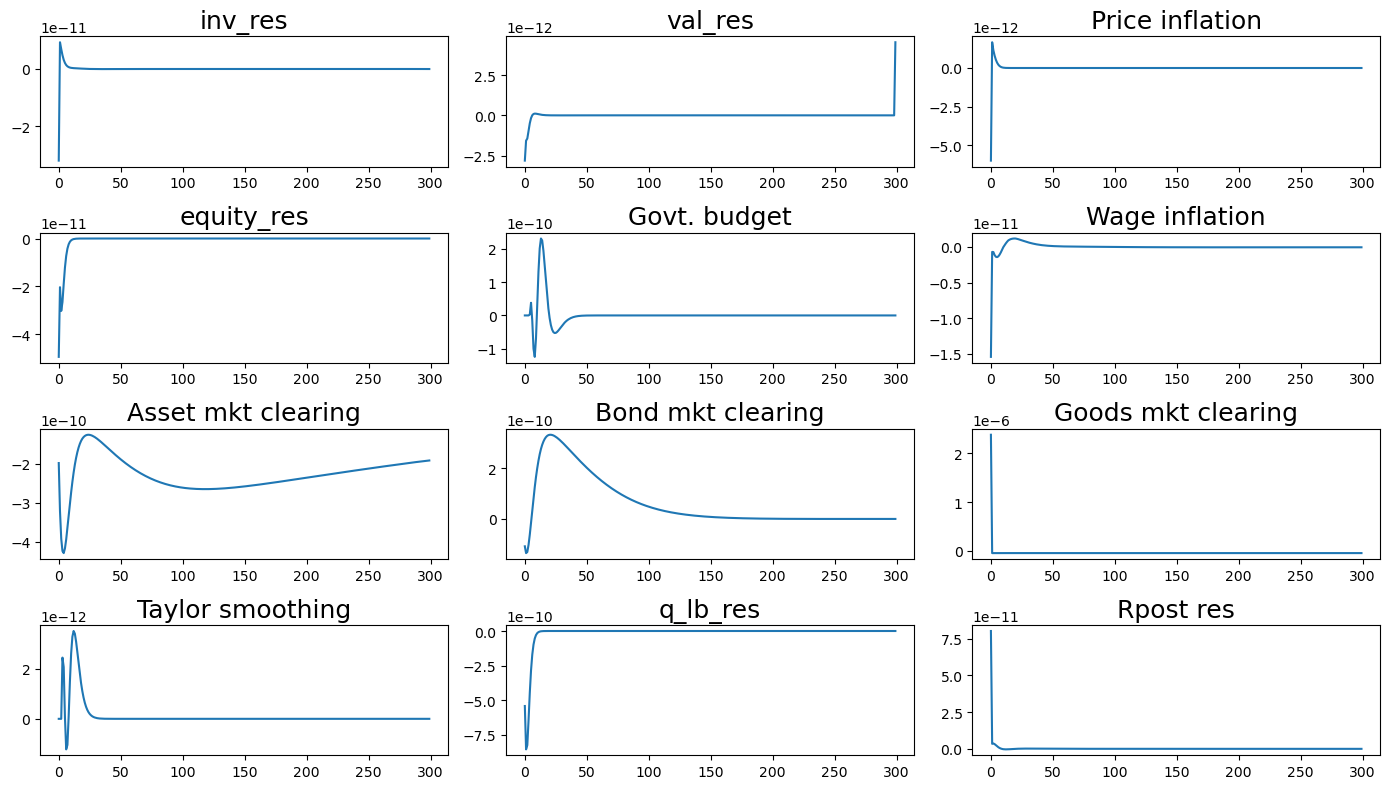

In [8]:
hank_lb_residuals = [k for k in hank_lb.outputs if is_residual(k)]
plot_residuals(irf_hank_lb_r, hank_lb_residuals)

## Plot

In [9]:
irf_hank_lb = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_lb_r)

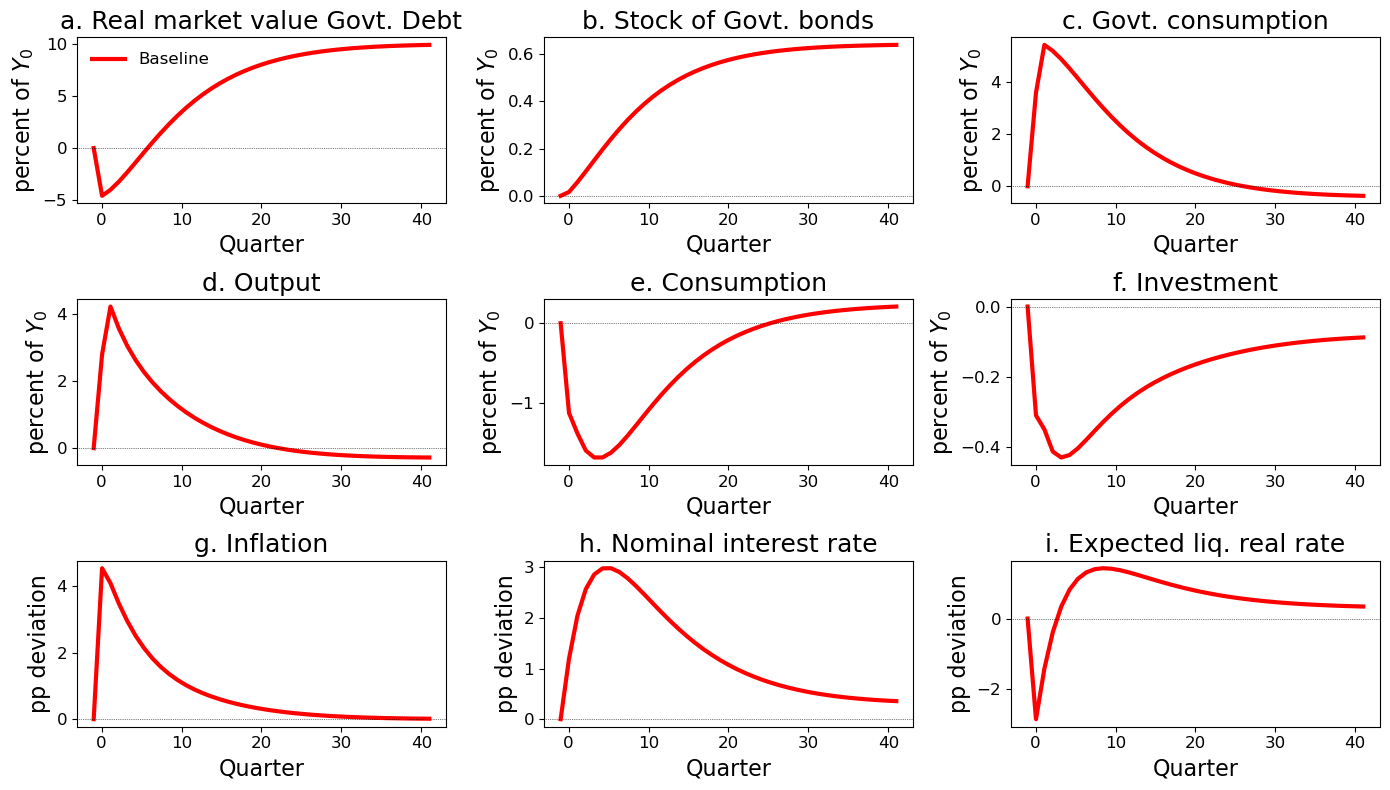

In [20]:
to_plot = {'Baseline': irf_hank_lb}
plot_cases = ['Baseline']
save_name = None
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'Bg_Q_lb', 'G', 'Y', 'C', 'I', 'pi', 'i', 'rb_e'], ncols=3)

## 2.2 Save baseline IRFs

In [12]:
# Print out values that can be mentioned in the text
for var in ['pi']:
    val = 400 * np.max(irf_hank_lb[var]+ss_hank_ini[var])
    print(f"{var} peaks at {val:.1f}")
    
for var in ['i', 'rb', 'ra']:
    val = 400 * np.max(irf_hank_lb[var])
    print(f"{var} deviation peaks at {val:.1f}")
    
for var in ['Y']:
    val = 100 * np.max(irf_hank_lb[var])
    print(f"{var} deviation peaks at {val:.1f}")
    
# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_lb, open(os.path.join("irfs", "irf_baseline.json"), 'w'), cls=NumpyEncoder, indent=4)
#json.dump(irf_hank_lb_r.internals["hh"], open("irf_baseline_internals_r.json", 'w'), cls=NumpyEncoder, indent=4)

pi peaks at 6.5
i deviation peaks at 3.0
rb deviation peaks at 1.4
ra deviation peaks at 0.6
Y deviation peaks at 4.2


 # 3. Decompose inflation and consumption into the component explained by the fiscal expansion and the component explained by the central bank response

In [13]:
# Study the impact of changing Gbar and Bbar while letting rbar at the original level
T = 300

drbar = np.zeros(T)
dGbar = (ss_hank_end_no_reaction['Gbar'] - ss_hank_ini['Gbar']) * np.ones(T)
dBgbar = (ss_hank_end_no_reaction['Bgbar'] - ss_hank_ini['Bgbar']) * np.ones(T)

shocks = {'Gbar': dGbar, 'Bgbar': dBgbar, 'rbar': drbar}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end_no_reaction, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_lb.solve_impulse_nonlinear_options['maxit'] = 100
hank_lb.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_lb_r_GbarBbar_no_reaction = hank_lb.solve_impulse_nonlinear(ss_hank_end_no_reaction, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Two-Asset HANK with long bonds for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration 0
   m

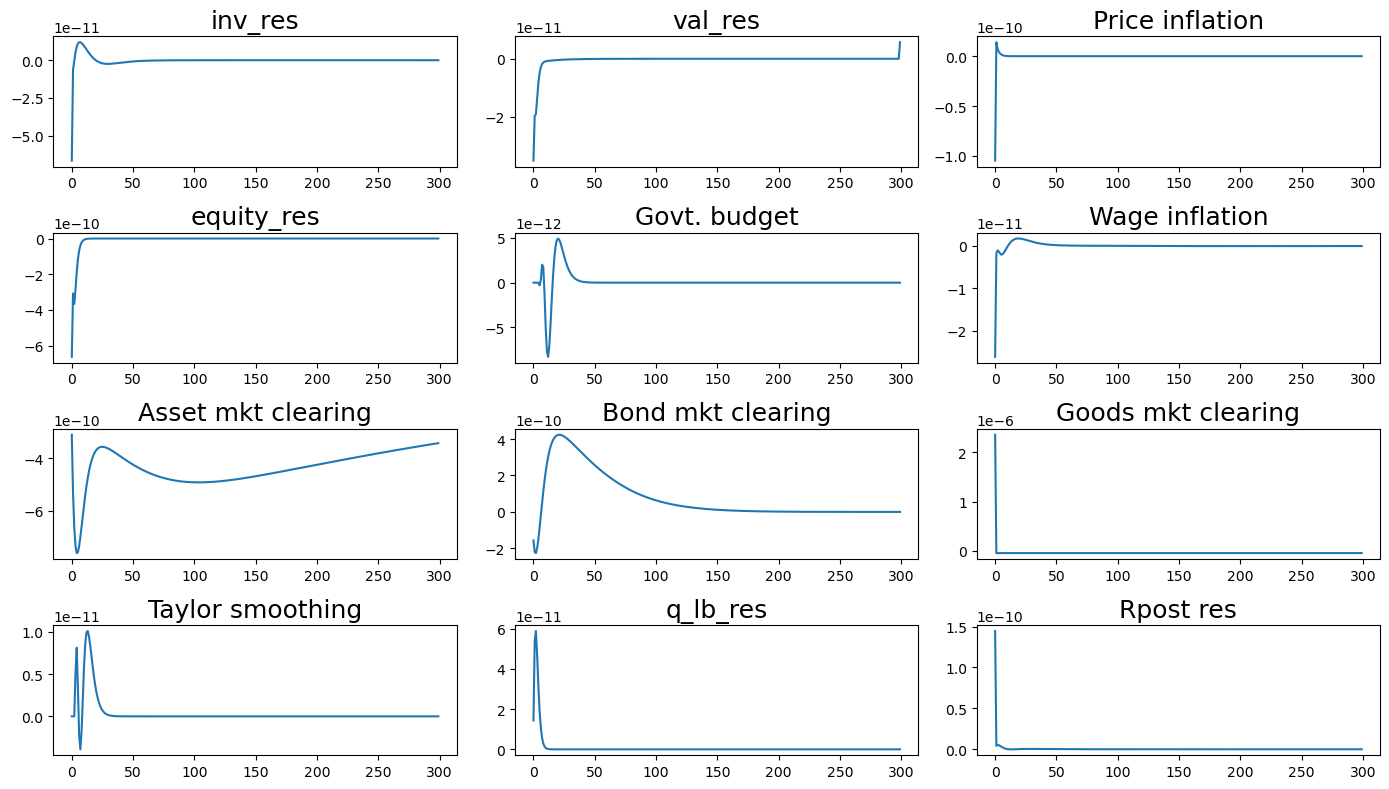

In [14]:
hank_lb_residuals = [k for k in hank_lb.outputs if is_residual(k)]
plot_residuals(irf_hank_lb_r_GbarBbar_no_reaction, hank_lb_residuals)

In [15]:
irf_hank_lb_GbarBbar_no_reaction = rebase_irf(ss_hank_end_no_reaction, ss_hank_ini, irf_hank_lb_r_GbarBbar_no_reaction)

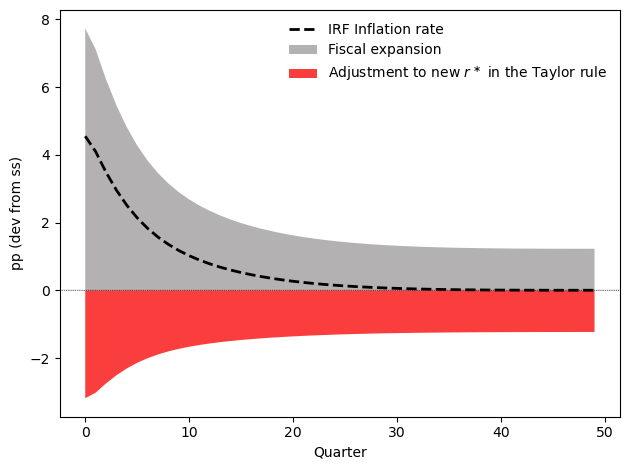

In [18]:
# Figure 5a: Inflation

d = {
    "Fiscal policy": 4 * 100 * (irf_hank_lb_GbarBbar_no_reaction['pi'][:50]),
    "Monetary policy": 4 * 100 * (irf_hank_lb['pi'][:50]-irf_hank_lb_GbarBbar_no_reaction['pi'][:50]) ,
    "Inflation": 4 * 100 * irf_hank_lb['pi'][:50],
}
df = pd.DataFrame(d)

cols = ['#b3b1b1', '#fa3e3e']
# split data into negative and positive values
df_pos = df[df >= 0].fillna(0.0)
df_neg = df[df < 0].fillna(0.0)
# initialize stackplot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(df.index, df["Inflation"], color="k", lw=2, ls="--", label="IRF Inflation rate")
# create and format stackplot
ax.stackplot(df_pos.index, df_pos["Fiscal policy"], df_pos["Monetary policy"],
            colors=cols)
# create and format stackplot
ax.stackplot(df_neg.index, df_neg["Fiscal policy"], df_neg["Monetary policy"],
            colors=cols,
            labels=["Fiscal expansion", r"Adjustment to new $r^\ast$ in the Taylor rule"])
ax.axhline(y=0.0, color='k', linewidth=0.5, linestyle=':')

ax.set_xlabel("Quarter")
ax.set_ylabel("pp (dev from ss)")
ax.legend(loc='upper right', frameon=False)

ax.axhline(y=0.0, color='k', linewidth=0.1, linestyle='-')
#ax.set_ylim(bottom=-1.5, top=6.5)
plt.tight_layout()

# save stackplot
savename = os.path.join("results", "2HANK_stack_pi.pdf")
plt.savefig(savename, format="pdf")
plt.show()
plt.close()

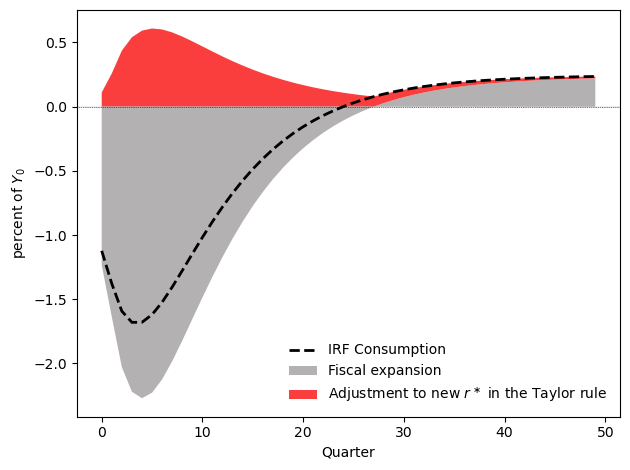

In [19]:
# Figure 5b: Consumption

d = {
    "Fiscal policy": 100 * irf_hank_lb_GbarBbar_no_reaction['C'][:50],
    "Monetary policy": 100 * (irf_hank_lb['C'][:50]-irf_hank_lb_GbarBbar_no_reaction['C'][:50]),
    "Consumption": 100 * irf_hank_lb['C'][:50],
}
df = pd.DataFrame(d)

cols = ['#b3b1b1', '#fa3e3e']
# split data into negative and positive values
df_pos = df[df >= 0].fillna(0.0)
df_neg = df[df < 0].fillna(0.0)
# initialize stackplot
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(df.index, df["Consumption"], color="k", lw=2, ls="--", label="IRF Consumption")
# create and format stackplot
ax.stackplot(df_pos.index, df_pos["Fiscal policy"], df_pos["Monetary policy"],
            colors=cols)
# create and format stackplot
ax.stackplot(df_neg.index, df_neg["Fiscal policy"], df_neg["Monetary policy"],
            colors=cols,
            labels=["Fiscal expansion", r"Adjustment to new $r^\ast$ in the Taylor rule"])
ax.axhline(y=0.0, color='k', linewidth=0.5, linestyle=':')

ax.set_xlabel("Quarter")
ax.set_ylabel(r"percent of $Y_0$")
ax.legend(loc='lower right', frameon=False)

ax.axhline(y=0.0, color='k', linewidth=0.1, linestyle='-')
#ax.set_ylim(bottom=-1.5, top=6.5)
plt.tight_layout()

# save stackplot
savename = savename = os.path.join("results", "2HANK_stack_C.pdf")
plt.savefig(savename, format="pdf")
plt.show()
plt.close()